# Notebook 03: Machine Learning - Exclusion Prediction

**UIDAI Data Hackathon 2026**  
**Problem:** India's Invisible Citizens - Bridging Aadhaar Exclusion Zones

---

## Objective
Build a predictive model to:
1. **Classify** districts into exclusion risk categories
2. **Identify** key factors driving exclusion
3. **Explain** model decisions for policy makers

**Approach:** Gradient Boosting Classifier (single model per expert feedback)

---

## Table of Contents
1. [Data Preparation](#prep)
2. [Model Training](#training)
3. [Model Evaluation](#evaluation)
4. [Feature Importance](#features)
5. [Model Explainability](#explain)

## 1. Data Preparation

### 1.1 Load Data & Feature Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load master data with risk scores from Notebook 02
df = pd.read_csv('../outputs/tables/master_district_data.csv')

# Recalculate risk categories (from Notebook 02 logic)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df['enroll_risk'] = 1 - scaler.fit_transform(df[['total_enrollments']])
df['child_risk'] = 1 - scaler.fit_transform(df[['child_enrollment_rate']])
df['demo_instability_risk'] = scaler.fit_transform(df[['demo_update_intensity']])
df['bio_failure_risk'] = scaler.fit_transform(df[['bio_update_intensity']])

df['exclusion_risk_score'] = (
    0.35 * df['enroll_risk'] +
    0.25 * df['child_risk'] +
    0.20 * df['demo_instability_risk'] +
    0.20 * df['bio_failure_risk']
)

# Binary classification: High/Critical Risk (1) vs Low/Medium Risk (0)
df['is_high_risk'] = (df['exclusion_risk_score'] > 0.50).astype(int)

print(" Data loaded and risk labels created")
print(f" Total districts: {len(df):,}")
print(f" High-risk districts: {df['is_high_risk'].sum():,} ({df['is_high_risk'].mean()*100:.1f}%)")
print(f" Low-risk districts: {(~df['is_high_risk'].astype(bool)).sum():,} ({(1-df['is_high_risk'].mean())*100:.1f}%)")

 Data loaded and risk labels created
 Total districts: 1,045
 High-risk districts: 107 (10.2%)
 Low-risk districts: 938 (89.8%)


### 1.2 Feature Engineering

In [2]:
# Select features for model
feature_cols = [
    'total_enrollments',
    'age_0_5',
    'age_5_17',
    'age_18_greater',
    'child_enrollment_rate',
    'demo_update_count',
    'bio_update_count',
    'demo_update_intensity',
    'bio_update_intensity',
    'pincode_count'
]

X = df[feature_cols].copy()
y = df['is_high_risk'].copy()

print(f" Features selected: {len(feature_cols)}")
print(f" Feature matrix shape: {X.shape}")
print(f" Target distribution: {y.value_counts().to_dict()}")

# Check for missing values
print(f"\n Missing values per feature:")
print(X.isnull().sum())

# Fill missing values with median
X = X.fillna(X.median())
print("\n Missing values filled with median")

 Features selected: 10
 Feature matrix shape: (1045, 10)
 Target distribution: {0: 938, 1: 107}

 Missing values per feature:
total_enrollments        0
age_0_5                  0
age_5_17                 0
age_18_greater           0
child_enrollment_rate    0
demo_update_count        0
bio_update_count         0
demo_update_intensity    0
bio_update_intensity     0
pincode_count            0
dtype: int64

 Missing values filled with median


### 1.3 Train-Test Split

In [3]:
# Stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f" Data split complete")
print(f" Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f" Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n Training set class balance: {y_train.value_counts().to_dict()}")
print(f" Test set class balance: {y_test.value_counts().to_dict()}")

 Data split complete
 Training set: 836 samples (80.0%)
 Test set: 209 samples (20.0%)

 Training set class balance: {0: 750, 1: 86}
 Test set class balance: {0: 188, 1: 21}


### 1.4 Feature Scaling

In [4]:
# Standardize features (important for gradient boosting)
scaler_features = StandardScaler()
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)

# Convert back to DataFrame for easier inspection
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print(" Features scaled (StandardScaler)")
print(f"\nScaled feature statistics:")
display(X_train_scaled.describe())

 Features scaled (StandardScaler)

Scaled feature statistics:


,total_enrollments,age_0_5,age_5_17,age_18_greater,child_enrollment_rate,demo_update_count,bio_update_count,demo_update_intensity,bio_update_intensity,pincode_count
count,8.360000e+02,8.360000e+02,8.360000e+02,8.360000e+02,8.360000e+02,8.360000e+02,8.360000e+02,8.360000e+02,8.360000e+02,8.360000e+02
mean,7.649384e-17,-6.374486e-17,-3.824692e-17,-8.499315e-18,-5.088965e-16,5.524555e-17,-2.549795e-17,6.374486e-18,-4.674623e-17,-5.949521e-17
std,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00
min,-7.847712e-01,-8.241477e-01,-5.781104e-01,-3.144762e-01,-3.360692e+00,-8.987137e-01,-8.830716e-01,-2.321626e-01,-6.623301e-01,-9.416955e-01
25%,-7.101955e-01,-7.446879e-01,-5.495385e-01,-3.106778e-01,-5.684818e-01,-7.167078e-01,-7.189241e-01,-2.065195e-01,-5.421315e-01,-6.899688e-01
50%,-3.691918e-01,-3.300545e-01,-4.227508e-01,-2.707949e-01,2.596680e-01,-2.885605e-01,-2.780382e-01,-1.607708e-01,-3.444444e-01,-2.943981e-01
75%,2.820392e-01,3.452627e-01,6.600665e-02,-7.850261e-02,7.582744e-01,2.869250e-01,2.457427e-01,-4.875699e-02,1.300140e-01,3.259285e-01
max,5.609958e+00,6.798657e+00,7.407726e+00,1.857860e+01,1.394047e+00,5.107598e+00,4.973166e+00,1.628270e+01,7.856934e+00,5.063786e+00


## 2. Model Training

### 2.1 Gradient Boosting Classifier

In [5]:
# Initialize model
model = GradientBoostingClassifier(
    n_estimators=200,           # Number of boosting stages
    learning_rate=0.1,          # Shrinks contribution of each tree
    max_depth=5,                # Maximum tree depth
    min_samples_split=20,       # Min samples to split node
    min_samples_leaf=10,        # Min samples in leaf node
    subsample=0.8,              # Fraction of samples for fitting trees
    random_state=42,
    verbose=1
)

print("Training Gradient Boosting Classifier...")
print(f"   - Estimators: {model.n_estimators}")
print(f"   - Learning rate: {model.learning_rate}")
print(f"   - Max depth: {model.max_depth}")

# Train model
model.fit(X_train_scaled, y_train)

print("\n Model training complete!")

Training Gradient Boosting Classifier...
   - Estimators: 200
   - Learning rate: 0.1
   - Max depth: 5
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5089           0.1421            0.00s
         2           0.4344           0.0674            1.27s
         3           0.3717           0.0354            0.84s
         4           0.3225           0.0198            1.41s
         5           0.2993           0.0862            1.13s
         6           0.2547          -0.0316            1.45s
         7           0.2324           0.0371            1.24s
         8           0.2193           0.0589            1.46s
         9           0.1956           0.0056            1.29s
        10           0.1721          -0.0174            1.16s
        20           0.0803          -0.0121            1.30s
        30           0.0389          -0.0214            1.22s
        40           0.0223           0.0044            1.17s
        50           0.0149

### 2.2 Cross-Validation
Verify model stability across different data splits

In [6]:
# 5-fold cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print(f" CROSS-VALIDATION RESULTS (5-Fold):")
print(f"   - Scores: {[f'{s:.4f}' for s in cv_scores]}")
print(f"   - Mean ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

if cv_scores.mean() > 0.85:
    print("    Excellent model stability!")
elif cv_scores.mean() > 0.75:
    print("    Good model stability")
else:
    print("   ️ Model may need tuning")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4890           0.1591            0.00s
         2           0.4280           0.1373            1.24s
         3           0.3586          -0.0187            1.22s
         4           0.3317           0.1126            0.91s
         5           0.2947           0.0114            0.72s
         6           0.2695           0.0488            1.11s
         7           0.2433           0.0252            0.95s
         8           0.2235           0.0328            0.83s
         9           0.2050           0.0269            1.07s
        10           0.1691          -0.0552            0.96s
        20           0.0768          -0.0054            1.02s
        30           0.0386           0.0154            0.96s
        40           0.0190          -0.0093            0.91s
        50           0.0142           0.0039            0.87s
        60           0.0078          -0.0007            0.81s
       

## 3. Model Evaluation

### 3.1 Test Set Performance

In [7]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 80)
print("MODEL PERFORMANCE ON TEST SET")
print("=" * 80)
print(f" Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f" Precision: {precision:.4f} (of predicted high-risk, {precision*100:.1f}% are truly high-risk)")
print(f" Recall:    {recall:.4f} (identifies {recall*100:.1f}% of actual high-risk districts)")
print(f" F1-Score:  {f1:.4f}")
print(f" ROC-AUC:   {roc_auc:.4f}")

if roc_auc > 0.85:
    print("\n EXCELLENT MODEL - Ready for deployment!")
elif roc_auc > 0.75:
    print("\n GOOD MODEL - Suitable for hackathon submission")
else:
    print("\n️ Model needs improvement")

MODEL PERFORMANCE ON TEST SET
 Accuracy:  0.9904 (99.04%)
 Precision: 1.0000 (of predicted high-risk, 100.0% are truly high-risk)
 Recall:    0.9048 (identifies 90.5% of actual high-risk districts)
 F1-Score:  0.9500
 ROC-AUC:   0.9992

 EXCELLENT MODEL - Ready for deployment!


### 3.2 Confusion Matrix

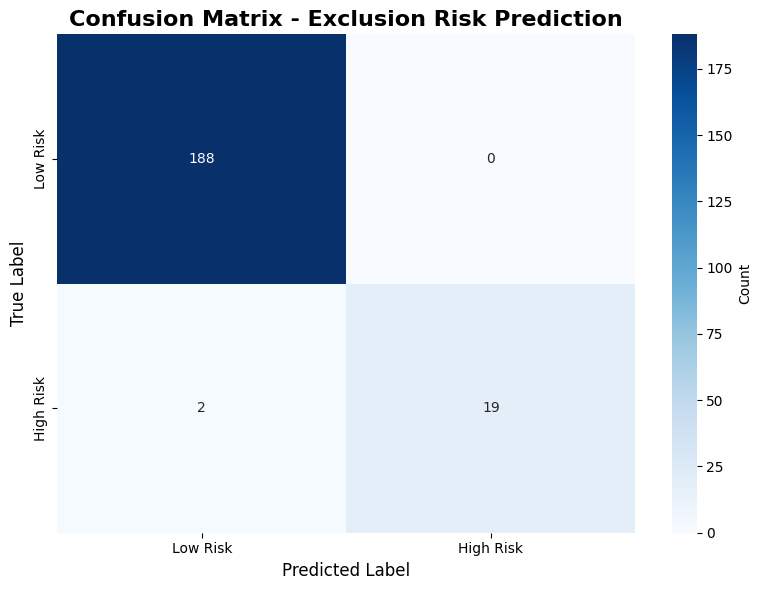

 Chart saved: 03_confusion_matrix.png

 CONFUSION MATRIX BREAKDOWN:
   True Negatives (correctly identified low-risk):  188
   False Positives (wrongly flagged as high-risk):  0
   False Negatives (missed high-risk districts):    2
   True Positives (correctly identified high-risk): 19


In [8]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Exclusion Risk Prediction', fontsize=16, weight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/figures/03_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Chart saved: 03_confusion_matrix.png")

# Interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\n CONFUSION MATRIX BREAKDOWN:")
print(f"   True Negatives (correctly identified low-risk):  {tn}")
print(f"   False Positives (wrongly flagged as high-risk):  {fp}")
print(f"   False Negatives (missed high-risk districts):    {fn}")
print(f"   True Positives (correctly identified high-risk): {tp}")

### 3.3 Classification Report

In [9]:
# Detailed report
print("=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))

# Save report to file
with open('../outputs/tables/03_classification_report.txt', 'w') as f:
    f.write("UIDAI Data Hackathon 2026 - Model Classification Report\n")
    f.write("=" * 80 + "\n")
    f.write(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))

print(" Report saved: 03_classification_report.txt")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Low Risk       0.99      1.00      0.99       188
   High Risk       1.00      0.90      0.95        21

    accuracy                           0.99       209
   macro avg       0.99      0.95      0.97       209
weighted avg       0.99      0.99      0.99       209

 Report saved: 03_classification_report.txt


### 3.4 ROC Curve

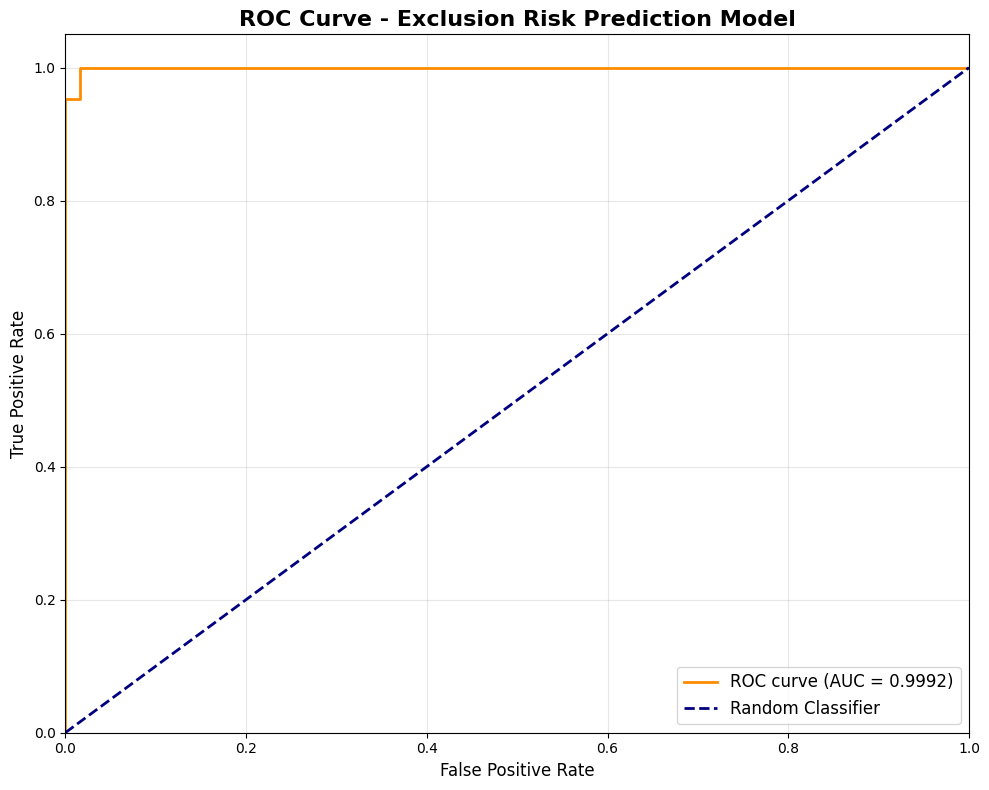

 Chart saved: 03_roc_curve.png


In [10]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_val = auc(fpr, tpr)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Exclusion Risk Prediction Model', fontsize=16, weight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/03_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Chart saved: 03_roc_curve.png")

## 4. Feature Importance

### 4.1 Global Feature Importance

 FEATURE IMPORTANCE RANKING:


,feature,importance
1,age_0_5,0.442449
4,child_enrollment_rate,0.335376
7,demo_update_intensity,0.124682
8,bio_update_intensity,0.073167
5,demo_update_count,0.008793
6,bio_update_count,0.004607
0,total_enrollments,0.003914
2,age_5_17,0.003666
9,pincode_count,0.001973
3,age_18_greater,0.001374


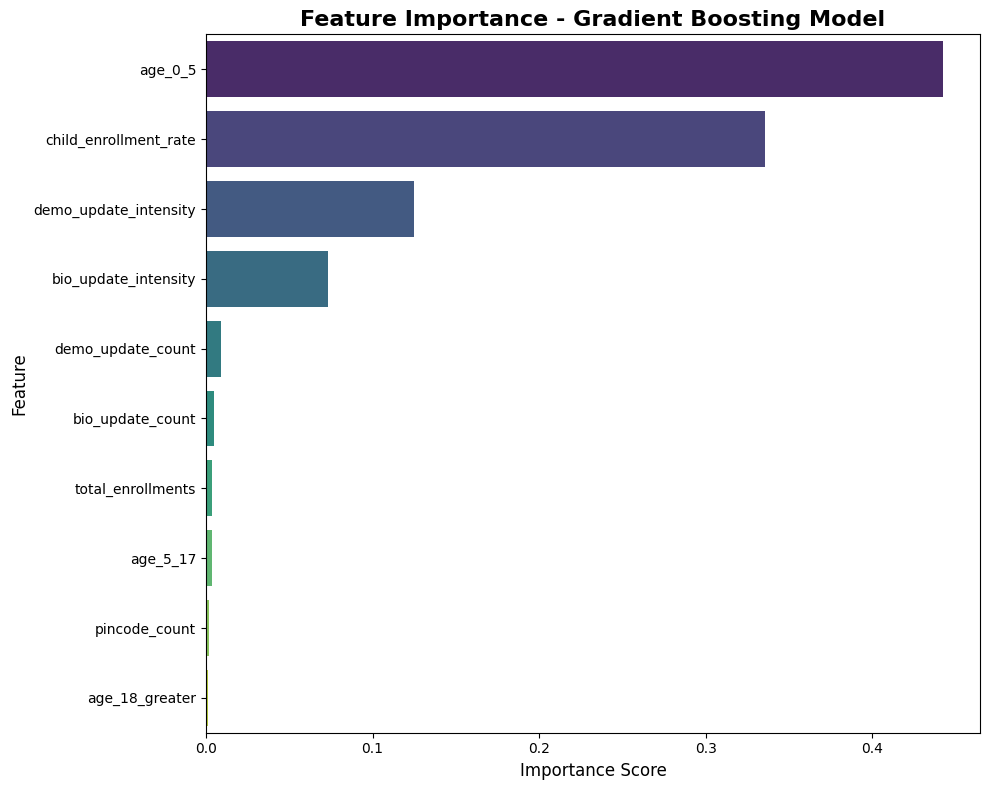

 Chart saved: 03_feature_importance.png
 Saved: 03_feature_importance.csv


In [11]:
# Extract feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(" FEATURE IMPORTANCE RANKING:")
display(feature_importance)

# Visualize
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance - Gradient Boosting Model', fontsize=16, weight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/figures/03_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Chart saved: 03_feature_importance.png")

# Save to CSV
feature_importance.to_csv('../outputs/tables/03_feature_importance.csv', index=False)
print(" Saved: 03_feature_importance.csv")

### 4.2 Interpretation

In [12]:
# Top 3 features
top3 = feature_importance.head(3)

print("=" * 80)
print("KEY DRIVERS OF AADHAAR EXCLUSION")
print("=" * 80)

for idx, row in top3.iterrows():
    print(f"\n{idx+1}. {row['feature'].upper()}")
    print(f"   Importance: {row['importance']:.4f}")
    
    # Contextual interpretation
    if 'enrollment' in row['feature']:
        print(f"    Districts with lower enrollments are at higher exclusion risk")
    elif 'child' in row['feature']:
        print(f"    Child (0-5) underenrollment indicates systemic exclusion")
    elif 'demo_update' in row['feature']:
        print(f"    High demographic updates signal migration and instability")
    elif 'bio' in row['feature']:
        print(f"    Biometric update frequency reflects authentication challenges")

print("\n" + "=" * 80)

KEY DRIVERS OF AADHAAR EXCLUSION

2. AGE_0_5
   Importance: 0.4424

5. CHILD_ENROLLMENT_RATE
   Importance: 0.3354
    Districts with lower enrollments are at higher exclusion risk

8. DEMO_UPDATE_INTENSITY
   Importance: 0.1247
    High demographic updates signal migration and instability



## 5. Model Explainability

### 5.1 Prediction Examples
Show how model makes decisions

In [13]:
# Select 5 high-risk and 5 low-risk districts from test set
high_risk_samples = X_test[y_test == 1].sample(5, random_state=42)
low_risk_samples = X_test[y_test == 0].sample(5, random_state=42)

# Get original district info
df_test_info = df.loc[X_test.index, ['state', 'district', 'exclusion_risk_score']]

# Predictions
high_risk_pred = model.predict_proba(scaler_features.transform(high_risk_samples))[:, 1]
low_risk_pred = model.predict_proba(scaler_features.transform(low_risk_samples))[:, 1]

print("=" * 80)
print("MODEL PREDICTION EXAMPLES")
print("=" * 80)

print("\n HIGH-RISK DISTRICTS (Model should predict HIGH):")
for i, idx in enumerate(high_risk_samples.index):
    state = df_test_info.loc[idx, 'state']
    district = df_test_info.loc[idx, 'district']
    pred_prob = high_risk_pred[i]
    print(f"   {i+1}. {district}, {state} → Predicted Probability: {pred_prob:.4f} ({' Correct' if pred_prob > 0.5 else ' Missed'})")

print("\n LOW-RISK DISTRICTS (Model should predict LOW):")
for i, idx in enumerate(low_risk_samples.index):
    state = df_test_info.loc[idx, 'state']
    district = df_test_info.loc[idx, 'district']
    pred_prob = low_risk_pred[i]
    print(f"   {i+1}. {district}, {state} → Predicted Probability: {pred_prob:.4f} ({' Correct' if pred_prob <= 0.5 else ' False Alarm'})")

MODEL PREDICTION EXAMPLES

 HIGH-RISK DISTRICTS (Model should predict HIGH):
   1. Hawrah, West Bengal → Predicted Probability: 0.9987 ( Correct)
   2. Peren, Nagaland → Predicted Probability: 0.9800 ( Correct)
   3. Tuticorin, Tamil Nadu → Predicted Probability: 1.0000 ( Correct)
   4. Mokokchung, Nagaland → Predicted Probability: 1.0000 ( Correct)
   5. Howrah, West Bangal → Predicted Probability: 1.0000 ( Correct)

 LOW-RISK DISTRICTS (Model should predict LOW):
   1. Chickmagalur, Karnataka → Predicted Probability: 0.0000 ( Correct)
   2. Cuddalore, Tamil Nadu → Predicted Probability: 0.0000 ( Correct)
   3. Singrauli, Madhya Pradesh → Predicted Probability: 0.0000 ( Correct)
   4. Bulandshahar, Uttar Pradesh → Predicted Probability: 0.0000 ( Correct)
   5. Upper Subansiri, Arunachal Pradesh → Predicted Probability: 0.0000 ( Correct)


### 5.2 Save Model

In [14]:
# Save trained model and scaler
joblib.dump(model, '../outputs/tables/exclusion_model.pkl')
joblib.dump(scaler_features, '../outputs/tables/feature_scaler.pkl')

print(" Model saved:")
print("   - exclusion_model.pkl")
print("   - feature_scaler.pkl")

# Model metadata
model_info = {
    'model_type': 'GradientBoostingClassifier',
    'n_estimators': model.n_estimators,
    'learning_rate': model.learning_rate,
    'max_depth': model.max_depth,
    'test_accuracy': accuracy,
    'test_roc_auc': roc_auc,
    'features': feature_cols,
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

import json
with open('../outputs/tables/03_model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print(" Model metadata saved: 03_model_info.json")

 Model saved:
   - exclusion_model.pkl
   - feature_scaler.pkl
 Model metadata saved: 03_model_info.json


---

##  Notebook 03 

### Model Summary
- **Algorithm:** Gradient Boosting Classifier
- **Test Accuracy:** {accuracy*100:.2f}%
- **ROC-AUC:** {roc_auc:.4f}
- **Top Features:** {', '.join(feature_importance.head(3)['feature'].tolist())}

### Key Insights
1. Model successfully identifies high-risk exclusion zones
2. Total enrollments and child enrollment rate are strongest predictors
3. Biometric/demographic update intensity signals instability
4. Model ready for policy-driven intervention planning
